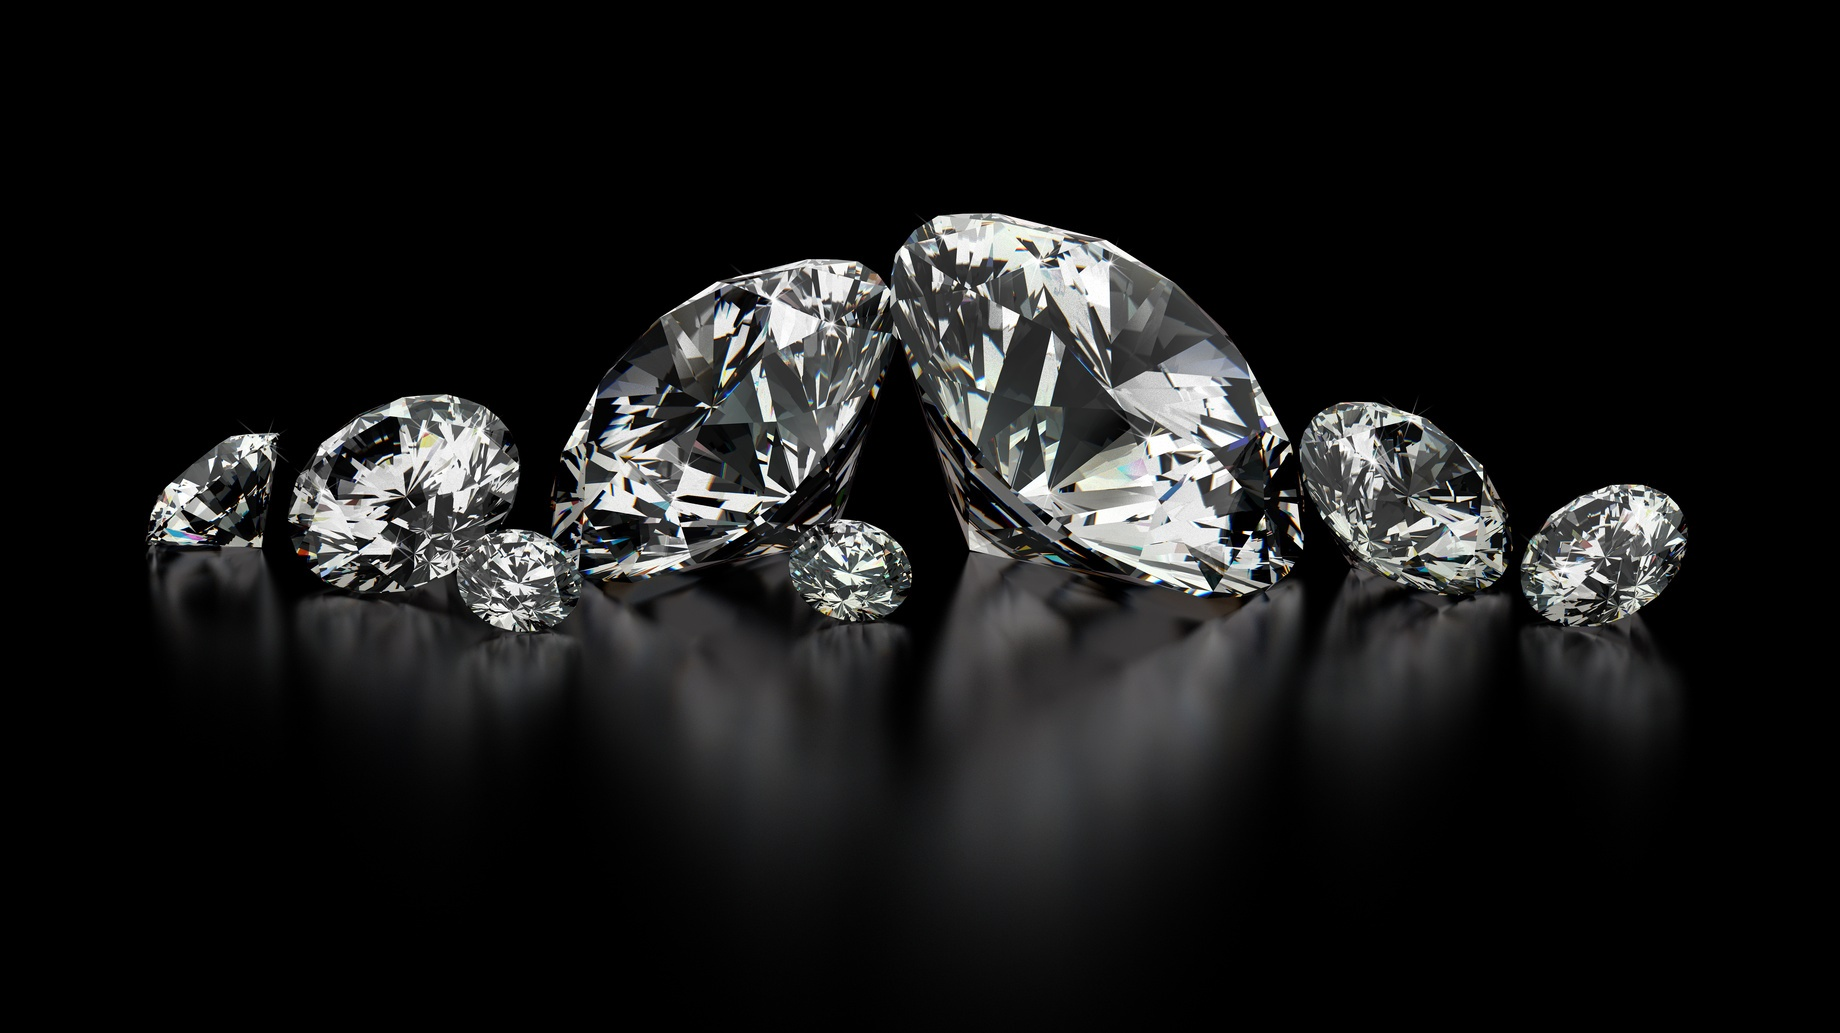

# Diamonds

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 

%matplotlib inline

In [ ]:
#load the dataset
url='../input/diamonds/diamonds.csv'
data=pd.read_csv(url)

The "Diamonds" dataset contains tens of thousands of records of diamonds and their price, as determined by experts. In this notebook we will analyze and draw conclusions from the data and build a model that can predict diamond prices according to their characteristics.

### **Features**
**Carat** : Carat weight of the Diamond.<br>
**Cut** : Describe cut quality of the diamond.
Quality in increasing order Fair, Good, Very Good, Premium, Ideal.<br>
**Color** : Color of the Diamond.
With D being the best and J the worst.<br>
**Clarity** : Diamond Clarity refers to the absence of the Inclusions and Blemishes.
(In order from Best to Worst, FL = flawless, I3= level 3 inclusions) FL, IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3.<br>
**Depth** : The Height of a Diamond, measured from the Culet to the table, divided by its average Girdle Diameter.<br>
**Table** : The Width of the Diamond's Table expressed as a Percentage of its Average Diameter.<br>
**Price** : the Price of the Diamond | *Targrt feature*.<br>
**X** : Length of the Diamond in mm.<br>
**Y** : Width of the Diamond in mm.<br>
**Z** : Height of the Diamond in mm.<br><br>
**Qualitative Features** (*Categorical*) : Cut, Color, Clarity.<br>
**Quantitative Features** (*Numerical*) : Carat, Depth , Table , Price , X , Y, Z.

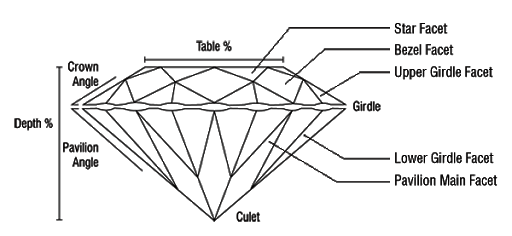

In [ ]:
#get information about the data features, the amount of instances and the amount of Nan values.
data.info()

There are no Nan values in the data.

In [ ]:
#first look
data.head()

 As you can see the column "Unnamed: 0" is an unnecessary index column. We will now delete it from the data.

In [ ]:
data=data.drop(columns='Unnamed: 0')

We will now apply the "describe()" function to get a general impression of the number ranges in each feature in the data.

In [ ]:
data.describe()

You can see that there are '0' values in the 'x', 'y', 'z' features. These values are invalid so I will delete them.

In [ ]:
data = data.drop(data.loc[data.x == 0].index)
data = data.drop(data.loc[data.y == 0].index)
data = data.drop(data.loc[data.z == 0].index)

 Let's see what field diamonds are in according "x, y, z" features.

In [ ]:
fig = plt.figure(figsize=(16,10))
ax = Axes3D(fig)

# plot 3D
ax.scatter(xs=data['x'], ys=data['y'], zs=data['z'], s=80, alpha=0.5)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')


As you can see, there are 3 cases of abnormalities much larger than average, out of tens of thousands of normal cases. In order not to damage the model exactly - we will delete them.

In [ ]:
data = data.drop(data.loc[data.y > 35].index)
data = data.drop(data.loc[data.z > 25].index)

We will add a feature to the dataset that represents the volume of the diamond - x * y * z. Delete them instead.

In [ ]:
data['volume']=data['x']*data['y']*data['z']
data=data.drop(['x','y','z'],axis=1)

Let's look at the relationship between volume and price and carat.

In [ ]:
# with sns.axes_style('dark'):
f, axes = plt.subplots(1, 2, figsize=(20, 7), sharex=False)
sns.regplot(x="volume", y="price", data=data,ax=axes[0], fit_reg=True, scatter_kws={"color": "khaki"}, line_kws={"color": "goldenrod"})
sns.regplot(x="volume", y="carat", data=data,ax=axes[1], fit_reg=True, scatter_kws={"color": "silver"}, line_kws={"color": "dimgray"})
axes[1].set_title('Volume - Carat',fontdict={'fontsize': 30,'fontweight':20,'color':'black','fontfamily':'Monotype Corsiva'})
axes[0].set_title('Volume - Price',fontdict={'fontsize': 30,'fontweight':20,'color':'black','fontfamily':'Monotype Corsiva'})
axes[1].text(250,0.5, "In general the carat of a diamond increases\n as its volume increases",size=15)
axes[0].text(55,20200, "Diamonds with a price of 100,000\n or more, have a volume of at\n least 150",size=15)
axes[0].axvline(150, ls='--',ymax=0.5)


Does the different categories have an effect on the price of the diamond?

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(20, 7), sharex=False,sharey=True)
sns.barplot(x="clarity",y="price", data=data,ax=axes[ 0])

g=sns.barplot(x="cut",y="price", data=data,ax=axes[ 1])
axes[1].set_title('Average price by category',y=1.08,fontdict={'fontsize': 40,'fontweight':20,'color':'black','fontfamily':'Monotype Corsiva'})

sns.barplot(x="color",y="price", data=data,ax=axes[ 2])


Seemingly categories have no effect on price. There are categories of the lowest level whose average price exceeds the average price of the categories at the high level.

We will split the dataset to 3 different parts. The 'top' data contains the diamonds at the high level of color, cut and clarity. The 'mid' data contains the medium level diamonds, and the 'low' data contains the lower level diamonds.We will check the price-volume ratio in each data.

In [ ]:
top=data[(data['color'].isin(['D','E']))& (data['cut'].isin(['Ideal','Premium']))& (data['clarity'].isin(['IF','VVS1','VVS2']))]
mid=data[(data['color'].isin(['F','G']))& (data['cut'].isin(['Good','Very Good']))& (data['clarity'].isin(['VS1','VS2']))]
low=data[(data['color'].isin(['H','I','J']))& (data['cut'].isin(['Fair']))& (data['clarity'].isin(['SI1','SI2','I1']))]


# take a sample of 200 diamonds from each data.
sns.set_style(style='whitegrid')
t=top.sample(n=200)
m=mid.sample(n=200)
l=low.sample(n=200)

#plot each data
f, axes = plt.subplots(1, 3, figsize=(25, 7), sharey=True,sharex=True)
ax = sns.scatterplot(x=t['price'], y=t['volume'],ax=axes[0])
axes[0].set_title('Top: Price - Volume',fontdict={'fontsize': 30,'fontweight':20,'color':'black','fontfamily':'Monotype Corsiva'})
ax = sns.scatterplot(x=m['price'],y=m['volume'],ax=axes[1])
axes[1].set_title('Mid: Price - Volume',fontdict={'fontsize': 30,'fontweight':20,'color':'black','fontfamily':'Monotype Corsiva'})
ax = sns.scatterplot(x=l['price'],y=l['volume'],ax=axes[2])
axes[2].set_title('Low: Price - Volume',fontdict={'fontsize': 30,'fontweight':20,'color':'black','fontfamily':'Monotype Corsiva'})

It can be seen that the expensive diamonds in 'low' have a very large volume, compared to the 'top' diamonds.

We will therefore change the values of the categorical features to numeric values according to their quality, so that the model will be affected by these characteristics.

In [ ]:
#replace the cut category with numbers 1-5
new_cut = {'Fair':1,'Good':2,'Very Good':3, 'Premium':4,'Ideal':5}
data['cut'] = data['cut'].map(new_cut);

#replace the color category with numbers 1-7
new_color = {'J':1,'I':2, 'H':3,'G':4,'F':5,'E':6,'D':7}
data['color'] = data['color'].map(new_color);

#replace the clarity category with numbers 1-8
new_clarity = {'I1':1,'SI2':2,'SI1':3,'VS2':4,'VS1':5,'VVS2':6,'VVS1':7,'IF':8}
data['clarity'] = data['clarity'].map(new_clarity);

We will now present a heatmap that illustrates the correlation between the features.

In [ ]:
correlation= data.corr()#calculate correlation of features
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(correlation,cmap="crest",annot=True,linewidths=2)#show the correlation on map.

## Model

 put the data into the 'X' without the price feature ("target"). And the price feature put into 'y'


In [ ]:
X = data.drop(['price'],axis=1)
y = data['price']

Split X and y into two parts - train and test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1) #the 'test' size is 10% of all instances in dataset

Standardize the data to allow the model to better study the data.

In [ ]:
scaler=StandardScaler()

X_train_s=X_train.copy()
X_train_s[['carat','table','volume','cut','depth']]=scaler.fit_transform(X_train_s[['carat','table','volume','cut','depth']])
normalized_x_train = pd.DataFrame(X_train_s, columns = X_train.columns)
X_train=normalized_x_train
X_test_s=X_test.copy()
X_test_s[['carat','table','volume','cut','depth']]=scaler.transform(X_test_s[['carat','table','volume','cut','depth']])
normalized_x_test = pd.DataFrame(X_test_s, columns = X_test.columns)
X_test=normalized_x_test

We will now look at the "dummy regressor" model. This is a stupid model that predicts the target by the mean. The output of this model can be compared to the output of a "linear regression" and "random forest regressor" models, thus evaluating the usefulness of the models.

In [ ]:
dummy_regr = DummyRegressor(strategy="mean")
# fit the model
dummy_regr.fit(X_train, y_train)
# predict the prices of X_test
dum_y_pred=dummy_regr.predict(X_test)

View model accuracy metrics:<br>
crross validation.<br>
R² - the percentage of variation (i.e. varies from 0 to 1) explained by the relationship between two variables.<br>
MAE - The Mean absolute error represents the average of the absolute difference between the actual and predicted values.<br>
MSE - Mean Squared Error represents the average of the squared difference between the original and predicted values. RMSE is root of MSE.<br>

In [ ]:
# print the accuracy by each measure:
print('Dummy regression accuracy: ')
msed = mean_squared_error(y_test, dum_y_pred)
rmsed = mean_squared_error(y_test, dum_y_pred)**0.5
maed = mean_absolute_error(y_test, dum_y_pred)
r2d = r2_score(y_test, dum_y_pred)
crossd = cross_val_score(estimator = dummy_regr, X = X_train, y = y_train, cv = 5)

print('Cross val     : ',crossd)
print('R2            : ', r2d)
print('MAE           : ', maed)
print('MSE (RMSE)    : ', msed,' (',rmsed,')')


We will define a function to display the predicted price difference from their real price.

In [ ]:
def differencePlot(y_test, y_predict, c1, c2):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set(xlabel = 'Predicted Price', ylabel = 'Actual Price - Predicted Price', title = 'between what is desired and what is present')
    ax.scatter(y_predict, y_test - y_predict, alpha = 0.15, color = c1)
    ax.axhline(y = 0, color = c2)

In [ ]:
differencePlot(y_test, dum_y_pred, 'steelblue', 'teal')

### Linear Regression

The "linear regression" formula calculates the straight line passing through the points in the sample. The line is calculated in such a way that the sum of the squares of the distances of the points from the line is the smallest.

In [ ]:
reg = LinearRegression()
# fit the model
reg.fit(X_train, y_train)
# predict the prices of X_test
lin_y_pred=reg.predict(X_test)

In [ ]:
# print the accuracy by each measure:
print('Linear regression accuracy: ')
crossl = cross_val_score(estimator = reg, X = X_train, y = y_train, cv = 4,verbose = 0)
msel = mean_squared_error(y_test, lin_y_pred)
rmsel = mean_squared_error(y_test, lin_y_pred)**0.5
mael = mean_absolute_error(y_test, lin_y_pred)
r2l = r2_score(y_test, lin_y_pred)

print('Cross val     : ',crossl)
print('R2            : ', r2l)
print('MAE           : ', mael)
print('MSE (RMSE)    : ', msel,' (',rmsel,')')

In [ ]:
differencePlot(y_test, lin_y_pred, 'brown', 'maroon')

### Random Forest Regressor

We will turn to the "Random Forest Regressor" model. This model works differently from that of the "linear regression" and determines the price of the diamond based on decision trees.

In [ ]:
rf = RandomForestRegressor()
# fit the model
rf.fit(X_train, y_train)
# predict the prices of X_test
rf_pre =rf.predict(X_test)

In [ ]:
# print the accuracy by each measure:
print('Random Forest Regressor accuracy: ')
crossr = cross_val_score(estimator = rf, X = X_train, y = y_train, cv = 4,verbose = 0)
mser = mean_squared_error(y_test, rf_pre)
rmser = mean_squared_error(y_test, rf_pre)**0.5
maer = mean_absolute_error(y_test, rf_pre)
r2r = r2_score(y_test, rf_pre)

print('Cross val     : ',crossr)
print('R2            : ', r2r)
print('MAE           : ', maer)
print('MSE (RMSE)    : ', mser,' (',rmser,')')

It can be concluded that the "Random Forest Regressor" model provides the best performance for us and performs the deviation lower than that of the "linear regression model".

In [ ]:
differencePlot(y_test, rf_pre, 'forestgreen', 'darkgreen')